# Health Insurance Risk Classifier
This project classifies individuals into health insurance risk categories based on their health metrics.
It uses a simple rule-based approach to categorize risk levels.

Author Carmine Giardino

## Step 1: Import the Necessary Libraries

Import all required Python libraries for data manipulation, analysis, database operations, and visualization.


In [1]:
# Import pandas for data handling
# Ref: https://pandas.pydata.org/docs/user_guide/index.html
import pandas as pd
# Import numpy for numerical operations
# Ref: https://numpy.org/doc/stable/user/absolute_beginners.html
import numpy as np
# Import sqlite3 for database operations
# Ref: https://docs.python.org/3/library/sqlite3.html
import sqlite3
# Import os for file system operations
# Ref: https://docs.python.org/3/library/os.html
import os
# Import matplotlib for plotting
# Ref: https://matplotlib.org/stable/tutorials/introductory/pyplot.html
import matplotlib.pyplot as plt
# Import seaborn for advanced visualizations
# Ref: https://seaborn.pydata.org/tutorial.html
import seaborn as sns
# Import TensorFlow and Keras for neural network
# Ref: https://www.tensorflow.org/api_docs
from tensorflow import keras
# Ref: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
from tensorflow.keras.models import Sequential
# Ref: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense
# Ref: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout
from tensorflow.keras.layers import Dense, Dropout
# Ref: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping
# Ref: https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical
from tensorflow.keras.utils import to_categorical
# Import scikit-learn for data splitting
# Ref: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
# Import metrics for model evaluation
# classification_report: Generates precision, recall, F1-score, and support for each class
# Ref: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
# confusion_matrix: Creates matrix showing actual vs. predicted classifications
# Ref: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
# precision_recall_fscore_support: Computes individual metric values for custom visualization
# Ref: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

## Step 2: Read the Health Insurance Data from CSV File

Load the health insurance dataset from a CSV file into a pandas DataFrame for analysis.


In [2]:
# Read CSV file into a pandas DataFrame
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
path = './data/health_insurance_data.csv'
df = pd.read_csv(path)
print("Data loaded successfully.")
# Display the first 5 rows to understand the data structure
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html
print(df.head())

Data loaded successfully.
    age     sex     bmi  children smoker     region      charges
0  19.0  female  27.900       0.0    yes  southwest  16884.92400
1  18.0    male  33.770       1.0     no  southeast   1725.55230
2  28.0    male  33.000       3.0     no  southeast   4449.46200
3  33.0    male  22.705       0.0     no  northwest  21984.47061
4  32.0    male  28.880       0.0     no  northwest   3866.85520


## Step 3: Clean the Data by Handling Missing Values

Handle missing values in the dataset using appropriate imputation strategies: mean for numeric columns and mode for categorical columns.


In [3]:
# Fill missing values in numeric columns with mean (common imputation strategy)
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html
for col in df.select_dtypes(include=[np.number]).columns:
    df[col] = df[col].fillna(df[col].mean())

# Fill missing values in categorical columns with mode (most frequent value)
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.Series.mode.html
for col in df.select_dtypes(exclude=[np.number]).columns:
    mode = df[col].mode()[0] if not df[col].mode().empty else None
    df[col] = df[col].fillna(mode)

print("Missing values handled.")
print(df.isnull().sum())

Missing values handled.
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


### Step 3.1: Encode Categorical Variables

Convert categorical text variables (sex, smoker, region) into numerical format using binary encoding and one-hot encoding for machine learning.


In [4]:
# Encode binary categorical variables (sex: male=1, female=0; smoker: yes=1, no=0)
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html
df['sex_encoded'] = df['sex'].map({'male': 1, 'female': 0})
df['smoker_encoded'] = df['smoker'].map({'yes': 1, 'no': 0})

# One-hot encode region (each region becomes a separate binary column)
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html
region_dummies = pd.get_dummies(df['region'], prefix='region')
df = pd.concat([df, region_dummies], axis=1)

print("Categorical variables encoded.")
print(df.head())
print(f"\nDataset shape: {df.shape}")

Categorical variables encoded.
    age     sex     bmi  children smoker     region      charges  sex_encoded  \
0  19.0  female  27.900       0.0    yes  southwest  16884.92400            0   
1  18.0    male  33.770       1.0     no  southeast   1725.55230            1   
2  28.0    male  33.000       3.0     no  southeast   4449.46200            1   
3  33.0    male  22.705       0.0     no  northwest  21984.47061            1   
4  32.0    male  28.880       0.0     no  northwest   3866.85520            1   

   smoker_encoded  region_northeast  region_northwest  region_southeast  \
0               1             False             False             False   
1               0             False             False              True   
2               0             False             False              True   
3               0             False              True             False   
4               0             False              True             False   

   region_southwest  
0        

## Step 4: Normalize Numeric Features for Better Comparison

Apply min-max normalization to scale numeric features to [0, 1] range for better comparison and analysis.


In [5]:
# Preserve original charges for later analysis
df['charges_original'] = df['charges'].copy()

# Normalize numeric columns using min-max scaling: (value - min) / (max - min)
# Ref: https://scikit-learn.org/stable/modules/preprocessing.html#normalization
numeric_cols = df.select_dtypes(include=[np.number]).columns
numeric_cols = [col for col in numeric_cols if col != 'charges_original']

for col in numeric_cols:
    min_val = df[col].min()
    max_val = df[col].max()
    df[col] = (df[col] - min_val) / (max_val - min_val)

print("Numeric features normalized.")
print(df.head())

Numeric features normalized.
        age     sex       bmi  children smoker     region   charges  \
0  0.021739  female  0.321227       0.0    yes  southwest  0.251611   
1  0.000000    male  0.479150       0.2     no  southeast  0.009636   
2  0.217391    male  0.458434       0.6     no  southeast  0.053115   
3  0.326087    male  0.181464       0.0     no  northwest  0.333010   
4  0.304348    male  0.347592       0.0     no  northwest  0.043816   

   sex_encoded  smoker_encoded  region_northeast  region_northwest  \
0          0.0             1.0             False             False   
1          1.0             0.0             False             False   
2          1.0             0.0             False             False   
3          1.0             0.0             False              True   
4          1.0             0.0             False              True   

   region_southeast  region_southwest  charges_original  
0             False              True       16884.92400  
1      

### Step 4.1: Save the Data to SQLite Database

Save both original and processed datasets to an SQLite database for persistence and SQL-based analysis.


In [6]:
# Connect to SQLite database (creates a file if it doesn't exist)
# Ref: https://docs.python.org/3/library/sqlite3.html
db_path = './data/health_insurance.db'
conn = sqlite3.connect(db_path)

# Save processed and original data to database
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_sql.html
df.to_sql('health_insurance_processed', conn, if_exists='replace', index=False)
df_original = pd.read_csv(path)
df_original.to_sql('health_insurance_original', conn, if_exists='replace', index=False)

conn.close()
print(f"Data saved to SQLite database: {db_path}")
print("Tables: 'health_insurance_original' and 'health_insurance_processed'")

Data saved to SQLite database: ./data/health_insurance.db
Tables: 'health_insurance_original' and 'health_insurance_processed'


## Step 5: Define Risk Classification Rules Based on Health Metrics

Create a rule-based function that assigns risk scores based on age, BMI, smoking status, and number of children, then categorizes individuals into Low (score < 4), Medium (4–6), or High (≥7) risk groups.


In [7]:
def classify_risk(row):
    """
    Classify insurance risk based on health metrics.
    Scoring: Age (0-4 pts), BMI (0-4 pts), Smoker (5 pts), Children (0-1 pt)
    Returns: 'Low' (< 4), 'Medium' (4-6), 'High' (≥ 7)
    """
    risk_score = 0
    
    # Age scoring
    if row['age'] > 0.7: risk_score += 4
    elif row['age'] > 0.4: risk_score += 2
    elif row['age'] > 0.2: risk_score += 1
    
    # BMI scoring
    if row['bmi'] > 0.7: risk_score += 4
    elif row['bmi'] > 0.5: risk_score += 2
    elif row['bmi'] > 0.3: risk_score += 1
    
    # Smoker (the highest impact)
    if row['smoker'] == 'yes': risk_score += 5
    
    # Children
    if row['children'] >= 3: risk_score += 1
    elif row['children'] >= 1: risk_score += 0.5
    
    if risk_score >= 7: return 'High'
    elif risk_score >= 4: return 'Medium'
    else: return 'Low'


## Step 6: Apply Risk Classification to All Records

Apply the risk classification function to each record and examine the distribution of risk categories.


In [8]:
# Apply risk classification to each row
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
df['risk_category'] = df.apply(classify_risk, axis=1)

print("Risk classification applied.")
print(df[['age', 'bmi', 'smoker', 'children', 'risk_category']].head(10))
print(f"\nRisk category distribution:")
print(df['risk_category'].value_counts())
print(f"\nPercentage distribution:")
print(df['risk_category'].value_counts(normalize=True) * 100)

Risk classification applied.
        age       bmi smoker  children risk_category
0  0.021739  0.321227    yes  0.000000        Medium
1  0.000000  0.479150     no  0.200000           Low
2  0.217391  0.458434     no  0.600000           Low
3  0.326087  0.181464     no  0.000000           Low
4  0.304348  0.347592     no  0.000000           Low
5  0.282609  0.263115     no  0.000000           Low
6  0.608696  0.470272     no  0.200000           Low
7  0.413043  0.316922     no  0.600000           Low
8  0.413043  0.373150     no  0.400000           Low
9  0.913043  0.265806     no  0.219147        Medium

Risk category distribution:
risk_category
Low       686
Medium    443
High      209
Name: count, dtype: int64

Percentage distribution:
risk_category
Low       51.270553
Medium    33.109118
High      15.620329
Name: proportion, dtype: float64


## Step 7: Save the Final Dataset with Risk Classifications to SQLite Database

Store the processed dataset with risk classifications in an SQLite database for persistence and future analysis.


In [9]:
# Reconnect to SQLite database
# Ref: https://docs.python.org/3/library/sqlite3.html#sqlite3.connect
conn = sqlite3.connect(db_path)

# Save the final dataset with risk classifications
# if_exists='replace' will drop the table if it exists and create a new one
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_sql.html
df.to_sql('health_insurance_with_risk', conn, if_exists='replace', index=False)

print(f"Dataset with risk classifications saved to 'health_insurance_with_risk' table")
print(f"Total records: {len(df)}")

Dataset with risk classifications saved to 'health_insurance_with_risk' table
Total records: 1338


## Step 8: Run SQL Queries to Confirm Correct Storage and Retrieval

Execute SQL queries to verify data storage and demonstrate database retrieval capabilities.


In [10]:
# Query 1: Count total records
query1 = "SELECT COUNT(*) as total_records FROM health_insurance_with_risk"
result1 = pd.read_sql_query(query1, conn)
print("Query 1 - Total records:")
print(result1)
print()

# Query 2: Count by risk category
query2 = """
SELECT risk_category, COUNT(*) as count 
FROM health_insurance_with_risk 
GROUP BY risk_category 
ORDER BY count DESC
"""
result2 = pd.read_sql_query(query2, conn)
print("Query 2 - Risk category distribution:")
print(result2)
print()

# Query 3: Average age and BMI by risk category
query3 = """
SELECT risk_category, 
       AVG(age) as avg_age, 
       AVG(bmi) as avg_bmi,
       COUNT(*) as count
FROM health_insurance_with_risk 
GROUP BY risk_category
"""
result3 = pd.read_sql_query(query3, conn)
print("Query 3 - Average age and BMI by risk category:")
print(result3)
print()

# Query 4: Sample records from each risk category
query4 = """
SELECT risk_category, age, bmi, smoker, children, charges_original
FROM health_insurance_with_risk
ORDER BY risk_category, charges_original DESC
LIMIT 15
"""
result4 = pd.read_sql_query(query4, conn)
print("Query 4 - Sample records:")
print(result4)

conn.close()
print("\nSQL queries completed. Database connection closed.")


Query 1 - Total records:
   total_records
0           1338

Query 2 - Risk category distribution:
  risk_category  count
0           Low    686
1        Medium    443
2          High    209

Query 3 - Average age and BMI by risk category:
  risk_category   avg_age   avg_bmi  count
0          High  0.571770  0.450128    209
1           Low  0.297415  0.351992    686
2        Medium  0.662921  0.437414    443

Query 4 - Sample records:
   risk_category       age       bmi smoker  children  charges_original
0           High  0.782609  0.846112    yes       0.0       63770.42801
1           High  0.586957  0.387409    yes       0.0       62592.87309
2           High  0.739130  0.498386    yes       0.6       60021.39897
3           High  0.282609  0.595507    yes       0.2       58571.07448
4           High  0.326087  0.526500    yes       0.0       55135.40209
5           High  0.913043  0.453054    yes       0.0       52590.82939
6           High  0.217391  0.549906    yes       0.2     

## Step 9: Load Data for Exploratory Data Analysis

Reload the processed dataset and prepare visualization settings for exploratory analysis.


In [11]:
# Set visualization style
# Ref: https://matplotlib.org/stable/tutorials/introductory/customizing.html
plt.style.use('default')
sns.set_palette("husl")

# Define consistent risk category order and colors
risk_order = ['Low', 'Medium', 'High']
risk_colors = ['green', 'orange', 'red']

# Create a plot directory
plot_dir = './plots'
os.makedirs(plot_dir, exist_ok=True)

# Load data from SQLite database
conn = sqlite3.connect(db_path)
query = "SELECT * FROM health_insurance_with_risk"
df_analysis = pd.read_sql_query(query, conn)
conn.close()

print(f"Data loaded for analysis. Shape: {df_analysis.shape}")
print(f"Plot directory: {plot_dir}")


Data loaded for analysis. Shape: (1338, 15)
Plot directory: ./plots


## Step 10: Visualize and Analyze the Data

Create visualizations to explore features and their relationships with risk classifications.

**Visualization Types:**
- **Histograms & Box Plots**: For continuous variables (Age, BMI, Charges) - show distributions and outliers
- **Bar Charts**: For categorical variables (Sex, Smoker, Region, Children) - show frequencies and relationships

### 10.1: Age Distribution Analysis

Examine age distribution across the dataset and compare age patterns between risk categories.


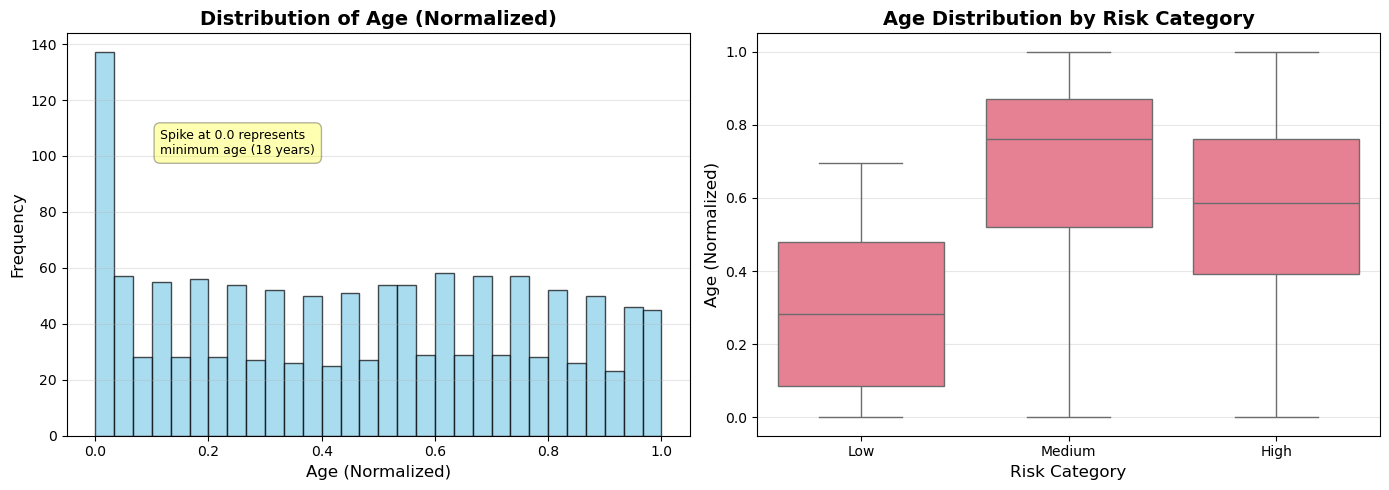

Mean age: 0.461, Median: 0.457
Plot saved: ./plots/01_age_distribution.png


In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of age
axes[0].hist(df_analysis['age'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Age (Normalized)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Age (Normalized)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
axes[0].annotate('Spike at 0.0 represents\nminimum age (18 years)', 
                 xy=(0.0, 0), xytext=(0.15, 0.7), 
                 textcoords='axes fraction',
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3),
                 fontsize=9)

# Box plot of age by risk category
sns.boxplot(data=df_analysis, x='risk_category', y='age', ax=axes[1], order=risk_order)
axes[1].set_xlabel('Risk Category', fontsize=12)
axes[1].set_ylabel('Age (Normalized)', fontsize=12)
axes[1].set_title('Age Distribution by Risk Category', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('./plots/01_age_distribution.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

print(f"Mean age: {df_analysis['age'].mean():.3f}, Median: {df_analysis['age'].median():.3f}")
print("Plot saved: ./plots/01_age_distribution.png")


### 10.2: BMI Distribution Analysis

Analyze Body Mass Index (BMI) distribution and its relationship with risk categories. BMI measures body fat based on height and weight.


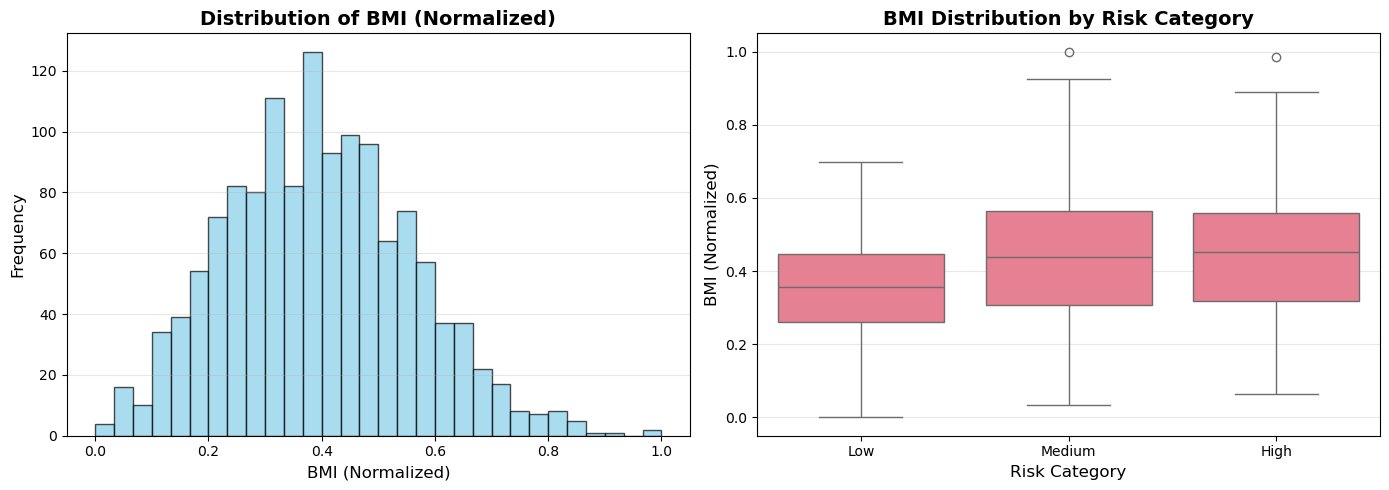

Mean BMI: 0.396, Median: 0.388
Plot saved: ./plots/02_bmi_distribution.png


In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of BMI
axes[0].hist(df_analysis['bmi'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('BMI (Normalized)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of BMI (Normalized)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Box plot of BMI by risk category
sns.boxplot(data=df_analysis, x='risk_category', y='bmi', ax=axes[1], order=risk_order)
axes[1].set_xlabel('Risk Category', fontsize=12)
axes[1].set_ylabel('BMI (Normalized)', fontsize=12)
axes[1].set_title('BMI Distribution by Risk Category', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('./plots/02_bmi_distribution.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

print(f"Mean BMI: {df_analysis['bmi'].mean():.3f}, Median: {df_analysis['bmi'].median():.3f}")
print("Plot saved: ./plots/02_bmi_distribution.png")


### 10.3: Insurance Charges Distribution Analysis

Explore insurance charges distribution and identify how costs vary across risk categories.


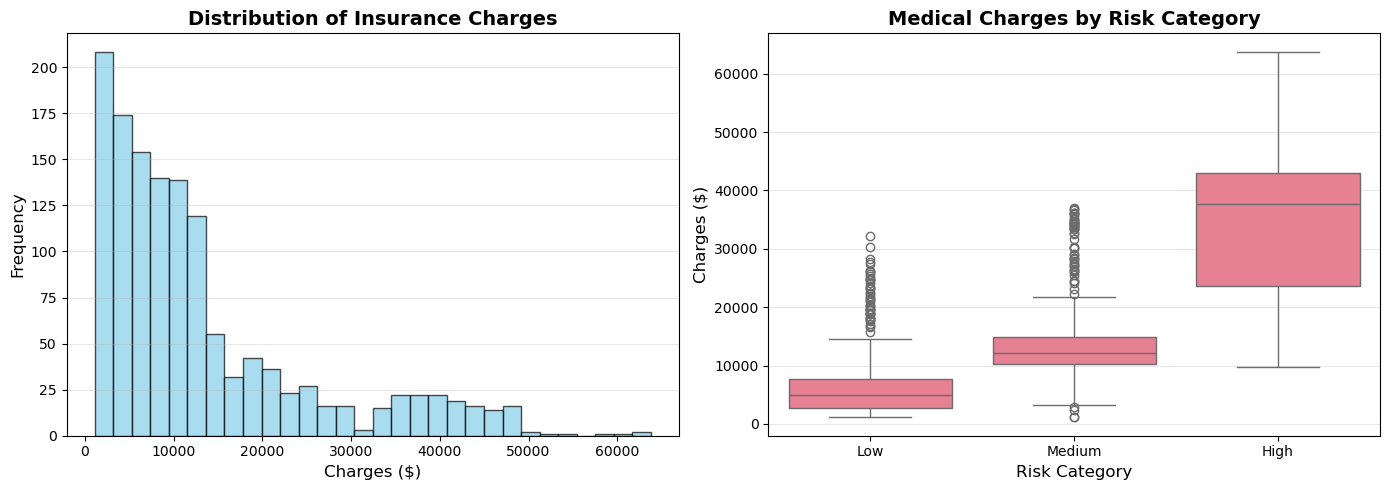

Mean: $13270.42, Median: $9382.03
Range: $1121.87 - $63770.43
Plot saved: ./plots/03_charges_distribution.png


In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of charges (using original values for interpretability)
axes[0].hist(df_analysis['charges_original'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Charges ($)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Insurance Charges', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Box plot of charges by risk category
sns.boxplot(data=df_analysis, x='risk_category', y='charges_original', ax=axes[1], order=risk_order)
axes[1].set_xlabel('Risk Category', fontsize=12)
axes[1].set_ylabel('Charges ($)', fontsize=12)
axes[1].set_title('Medical Charges by Risk Category', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('./plots/03_charges_distribution.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

print(f"Mean: ${df_analysis['charges_original'].mean():.2f}, Median: ${df_analysis['charges_original'].median():.2f}")
print(f"Range: ${df_analysis['charges_original'].min():.2f} - ${df_analysis['charges_original'].max():.2f}")
print("Plot saved: ./plots/03_charges_distribution.png")


### 10.4: Smoker Status Analysis

Investigate the impact of smoking status on risk categories. Smoking is a critical factor in health insurance risk assessment.


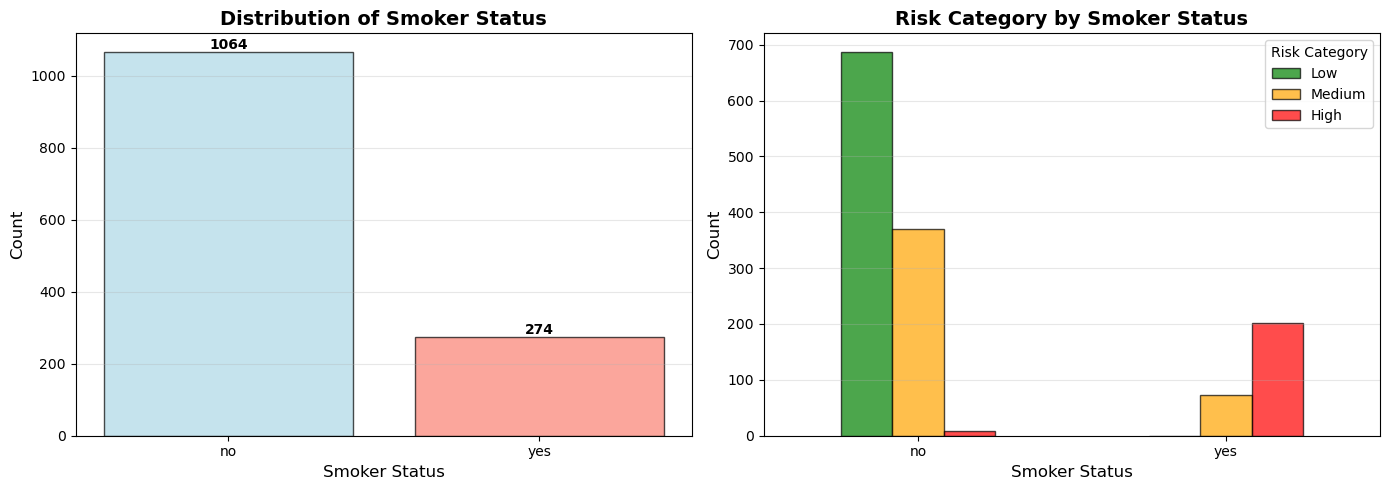

Smoker status by risk category:
risk_category  High  Low  Medium
smoker                          
no                8  686     370
yes             201    0      73
Plot saved: ./plots/04_smoker_analysis.png


In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Smoker distribution
smoker_counts = df_analysis['smoker'].value_counts()
axes[0].bar(smoker_counts.index, smoker_counts.values, color=['lightblue', 'salmon'], 
            edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Smoker Status', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Distribution of Smoker Status', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, (status, count) in enumerate(smoker_counts.items()):
    axes[0].text(i, count, str(count), ha='center', va='bottom', fontweight='bold')

# Smoker status by risk category
smoker_risk = pd.crosstab(df_analysis['smoker'], df_analysis['risk_category'])
smoker_risk[risk_order].plot(kind='bar', ax=axes[1], color=risk_colors, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Smoker Status', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Risk Category by Smoker Status', fontsize=14, fontweight='bold')
axes[1].legend(title='Risk Category')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('./plots/04_smoker_analysis.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

print("Smoker status by risk category:")
print(smoker_risk)
print("Plot saved: ./plots/04_smoker_analysis.png")


### 10.5: Sex Distribution Analysis

Analyze the distribution of sex (gender) and its relationship with risk categories.


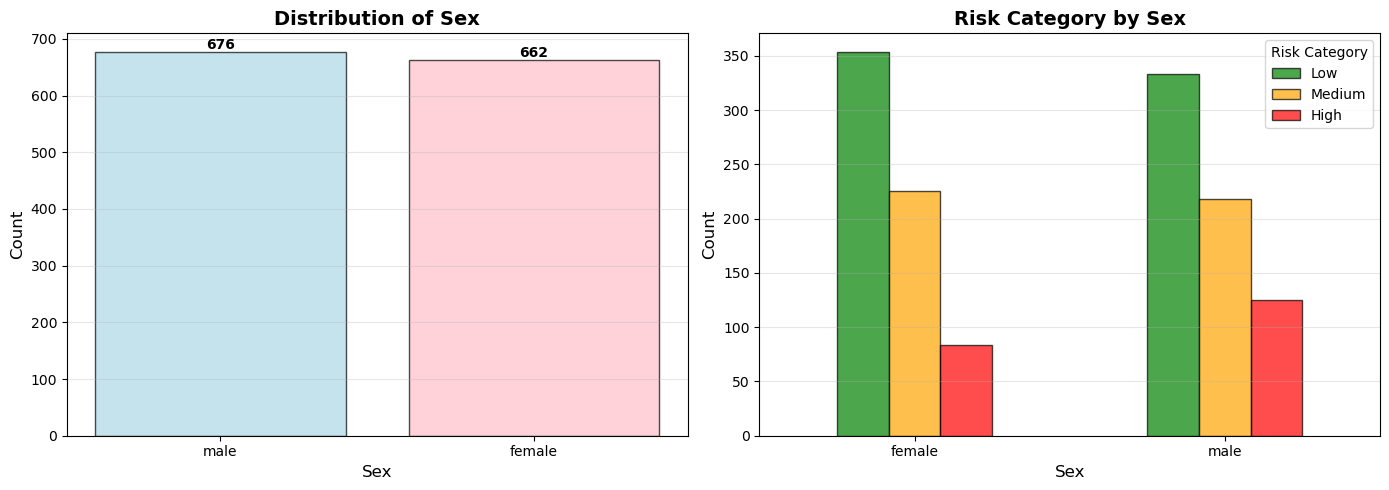

Sex distribution by risk category:
risk_category  High  Low  Medium
sex                             
female           84  353     225
male            125  333     218
Plot saved: ./plots/05_sex_analysis.png


In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sex distribution
sex_counts = df_analysis['sex'].value_counts()
axes[0].bar(sex_counts.index, sex_counts.values, color=['lightblue', 'pink'], 
            edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Sex', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Distribution of Sex', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, (sex, count) in enumerate(sex_counts.items()):
    axes[0].text(i, count, str(count), ha='center', va='bottom', fontweight='bold')

# Sex distribution by risk category
sex_risk = pd.crosstab(df_analysis['sex'], df_analysis['risk_category'])
sex_risk[risk_order].plot(kind='bar', ax=axes[1], color=risk_colors, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Sex', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Risk Category by Sex', fontsize=14, fontweight='bold')
axes[1].legend(title='Risk Category')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('./plots/05_sex_analysis.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

print("Sex distribution by risk category:")
print(sex_risk)
print("Plot saved: ./plots/05_sex_analysis.png")


### 10.6: Region Distribution Analysis

Examine geographical distribution across regions and analyze how regional factors impact risk categories.


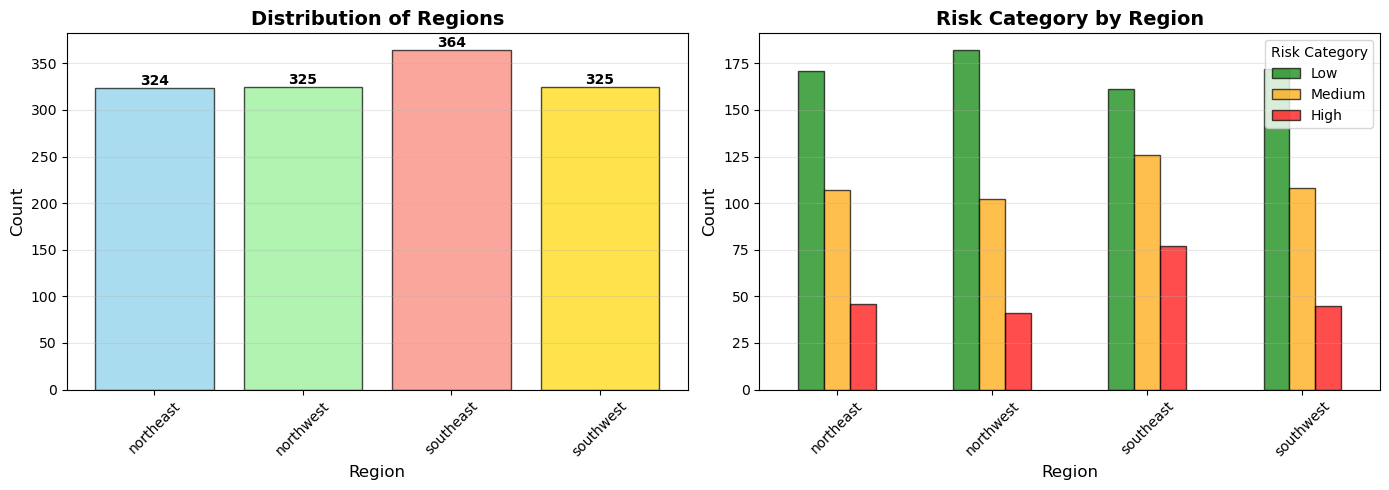

Region distribution by risk category:
risk_category  High  Low  Medium
region                          
northeast        46  171     107
northwest        41  182     102
southeast        77  161     126
southwest        45  172     108
Plot saved: ./plots/06_region_analysis.png


In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Region distribution
region_counts = df_analysis['region'].value_counts().sort_index()
axes[0].bar(region_counts.index, region_counts.values, 
            color=['skyblue', 'lightgreen', 'salmon', 'gold'], 
            edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Region', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Distribution of Regions', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)
for i, (region, count) in enumerate(region_counts.items()):
    axes[0].text(i, count, str(count), ha='center', va='bottom', fontweight='bold')

# Region distribution by risk category
region_risk = pd.crosstab(df_analysis['region'], df_analysis['risk_category'])
region_risk[risk_order].plot(kind='bar', ax=axes[1], color=risk_colors, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Region', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Risk Category by Region', fontsize=14, fontweight='bold')
axes[1].legend(title='Risk Category')
axes[1].grid(axis='y', alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('./plots/06_region_analysis.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

print("Region distribution by risk category:")
print(region_risk)
print("Plot saved: ./plots/06_region_analysis.png")


### 10.7: Children Distribution Analysis

Investigate how the number of dependents correlates with risk classifications.


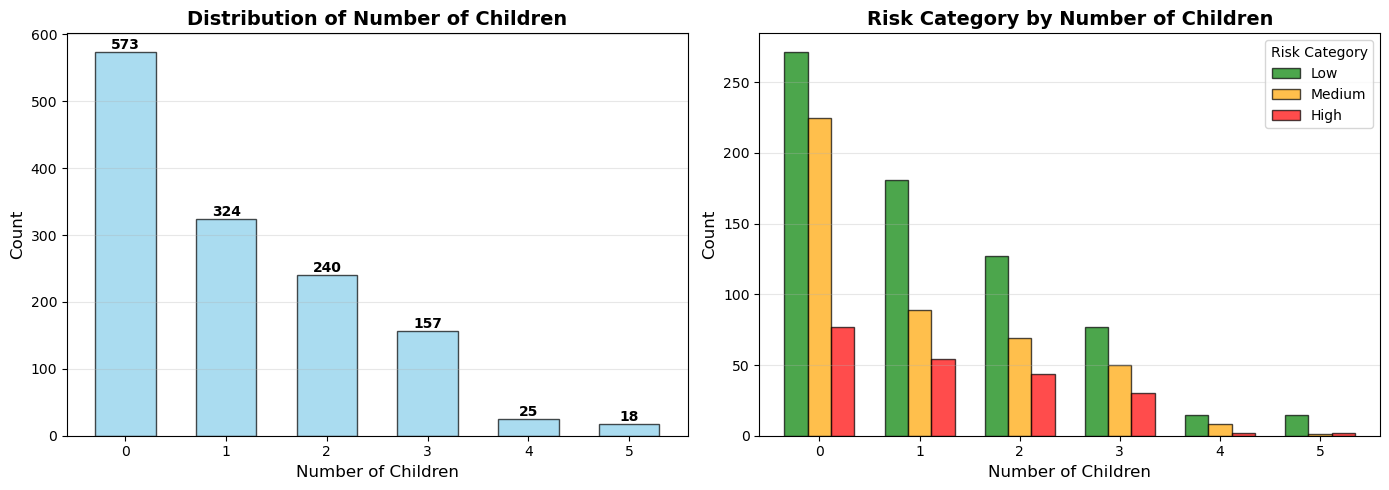

Children distribution analysis:
risk_category      High  Low  Medium
children_original                   
0.0                  77  271     225
1.0                  54  181      89
2.0                  44  127      69
3.0                  30   77      50
4.0                   2   15       8
5.0                   2   15       1
Plot saved to: ./plots/07_children_analysis.png


In [18]:
# Load original children values (since they were normalized)
conn_temp = sqlite3.connect(db_path)
df_children_original = pd.read_sql_query("SELECT children FROM health_insurance_original", conn_temp)
conn_temp.close()

df_analysis['children_original'] = df_children_original['children']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Children distribution using original values
children_counts = df_analysis['children_original'].value_counts().sort_index()
# Use range for x-positions to ensure proper spacing
x_positions = range(len(children_counts))
axes[0].bar(x_positions, children_counts.values, 
            color='skyblue', edgecolor='black', alpha=0.7, width=0.6)
axes[0].set_xlabel('Number of Children', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Distribution of Number of Children', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_positions)
axes[0].set_xticklabels([str(int(x)) for x in children_counts.index])
axes[0].grid(axis='y', alpha=0.3)

# Add count labels
for i, count in enumerate(children_counts.values):
    axes[0].text(i, count, str(int(count)), ha='center', va='bottom', fontweight='bold')

# Children distribution by risk category using original values
children_risk = pd.crosstab(df_analysis['children_original'], df_analysis['risk_category'])
children_risk[risk_order].plot(kind='bar', ax=axes[1], 
                               color=risk_colors,
                               edgecolor='black', alpha=0.7, width=0.7)
axes[1].set_xlabel('Number of Children', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Risk Category by Number of Children', fontsize=14, fontweight='bold')
axes[1].legend(title='Risk Category', loc='upper right')
axes[1].grid(axis='y', alpha=0.3)
# Format x-axis labels as integers
axes[1].set_xticklabels([str(int(float(label.get_text()))) for label in axes[1].get_xticklabels()], rotation=0)

plt.tight_layout()
plt.savefig('./plots/07_children_analysis.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

print("Children distribution analysis:")
print(children_risk)
print("Plot saved to: ./plots/07_children_analysis.png")


### 10.8: Risk Category Distribution Analysis

Visualize the overall distribution of risk categories using bar and pie charts.


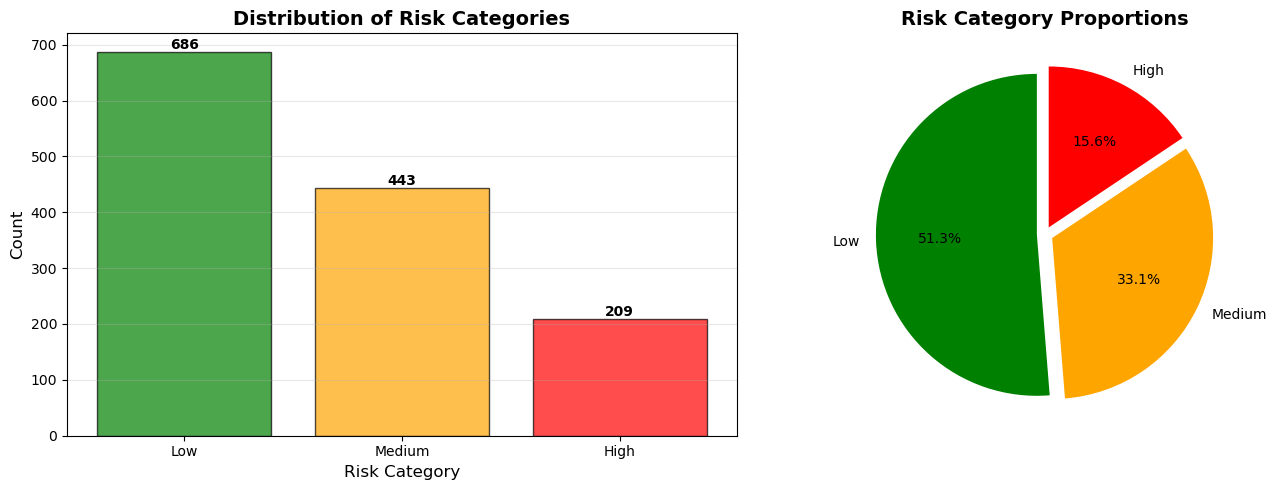

Risk category distribution:
risk_category
Low       686
Medium    443
High      209
Name: count, dtype: int64
Plot saved: ./plots/08_risk_category_distribution.png


In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of risk categories
risk_counts = df_analysis['risk_category'].value_counts().reindex(risk_order)
axes[0].bar(risk_counts.index, risk_counts.values, color=risk_colors, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Risk Category', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Distribution of Risk Categories', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, (category, count) in enumerate(risk_counts.items()):
    axes[0].text(i, count, str(count), ha='center', va='bottom', fontweight='bold')

# Pie chart of risk categories
wedges, texts, autotexts = axes[1].pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%',
            colors=risk_colors, startangle=90, explode=(0.05, 0.05, 0.05))
axes[1].set_title('Risk Category Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('./plots/08_risk_category_distribution.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

print("Risk category distribution:")
print(risk_counts)
print("Plot saved: ./plots/08_risk_category_distribution.png")


## Step 11: Examine Correlations Between Variables

Analyze relationships between features using correlation analysis to identify key patterns and predictors.


### 11.1: Correlation Matrix

Calculate and visualize correlation coefficients between numeric features. Pearson correlation ranges from -1 (perfect negative) to +1 (perfect positive).

Correlation Matrix:
                       age       bmi  children  sex_encoded  smoker_encoded  \
age               1.000000  0.110162  0.042725    -0.020012       -0.025469   
bmi               0.110162  1.000000  0.012047     0.046175        0.004136   
children          0.042725  0.012047  1.000000     0.016481        0.007331   
sex_encoded      -0.020012  0.046175  0.016481     1.000000        0.076185   
smoker_encoded   -0.025469  0.004136  0.007331     0.076185        1.000000   
charges_original  0.298341  0.198602  0.068898     0.057292        0.787251   

                  charges_original  
age                       0.298341  
bmi                       0.198602  
children                  0.068898  
sex_encoded               0.057292  
smoker_encoded            0.787251  
charges_original          1.000000  




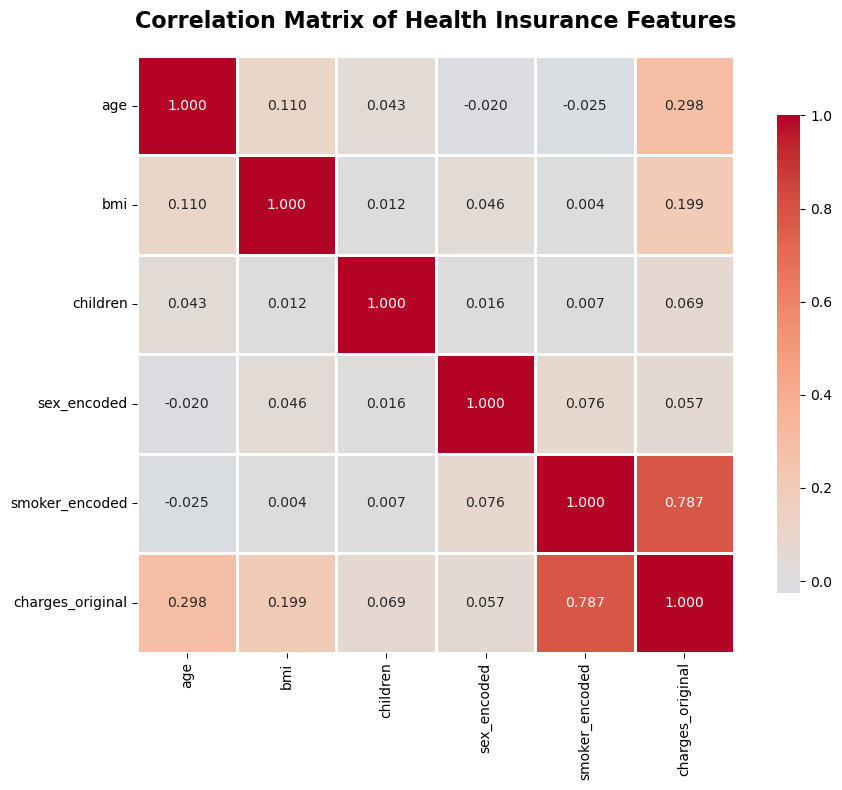

Correlations with Insurance Charges (sorted by strength):
  smoker_encoded      : +0.7873
  age                 : +0.2983
  bmi                 : +0.1986
  children            : +0.0689
  sex_encoded         : +0.0573
Plot saved: ./plots/09_correlation_matrix.png


In [20]:
# Select numeric features for correlation analysis
numeric_features = ['age', 'bmi', 'children', 'sex_encoded', 'smoker_encoded', 'charges_original']
correlation_data = df_analysis[numeric_features].copy()

# Calculate correlation matrix using Pearson's correlation coefficient
# This computes pairwise correlations between all numeric features
# Values range from -1 (perfect negative correlation) to +1 (perfect positive correlation)
# Values near 0 indicate no linear relationship between variables
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html
correlation_matrix = correlation_data.corr()

print("Correlation Matrix:")
print(correlation_matrix)
print("\n" + "="*80 + "\n")

# Create heatmap visualization
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, fmt='.3f')
plt.title('Correlation Matrix of Health Insurance Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('./plots/09_correlation_matrix.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

# Print strongest correlations with charges
print("Correlations with Insurance Charges (sorted by strength):")
charges_corr = correlation_matrix['charges_original'].drop('charges_original').sort_values(key=abs, ascending=False)
for feature, corr in charges_corr.items():
    print(f"  {feature:20s}: {corr:+.4f}")
print("Plot saved: ./plots/09_correlation_matrix.png")


## Step 12: Summarize Key Findings

Compile and present the most important insights discovered through the exploratory data analysis, including risk distributions, correlations, and actionable observations.


In [21]:
# Summarize the exploratory data analysis results
# This section provides a comprehensive overview of insights gained from the data
print("="*80)
print("KEY FINDINGS FROM EXPLORATORY DATA ANALYSIS")
print("="*80)
print()

# 1. Dataset Overview
print("1. DATASET OVERVIEW")
print("-" * 40)
print(f"   Total records: {len(df_analysis)}")
print(f"   Features analyzed: {len(numeric_features)}")
print(f"   Risk categories: {df_analysis['risk_category'].nunique()}")
print()

# 2. Risk Distribution
print("2. RISK CATEGORY DISTRIBUTION")
print("-" * 40)
risk_dist = df_analysis['risk_category'].value_counts().reindex(risk_order)
for category, count in risk_dist.items():
    percentage = (count / len(df_analysis)) * 100
    print(f"   {category:8s}: {count:4d} ({percentage:5.1f}%)")
print()

# 3. Correlation Insights
print("3. CORRELATION INSIGHTS")
print("-" * 40)
print(f"   Strongest positive correlation with charges:")
max_corr = charges_corr.idxmax()
print(f"     - {max_corr}: {charges_corr[max_corr]:+.4f}")
print()
print(f"   Top 3 factors influencing insurance charges:")
for i, (feature, corr) in enumerate(charges_corr.head(3).items(), 1):
    print(f"     {i}. {feature:20s}: {corr:+.4f}")
print()

# 4. Smoker Impact
print("4. SMOKER STATUS IMPACT")
print("-" * 40)
smoker_charges = df_analysis.groupby('smoker')['charges_original'].agg(['mean', 'median', 'std'])
print(f"   Non-smokers - Mean charges: ${smoker_charges.loc['no', 'mean']:,.2f}")
print(f"   Smokers     - Mean charges: ${smoker_charges.loc['yes', 'mean']:,.2f}")
smoker_diff = smoker_charges.loc['yes', 'mean'] - smoker_charges.loc['no', 'mean']
smoker_pct = (smoker_diff / smoker_charges.loc['no', 'mean']) * 100
print(f"   Difference: ${smoker_diff:,.2f} ({smoker_pct:+.1f}%)")
print()

# 5. Age and BMI Analysis
print("5. AGE AND BMI PATTERNS")
print("-" * 40)
risk_stats = df_analysis.groupby('risk_category')[['age', 'bmi']].mean().sort_index()
print("   Average values by risk category (normalized):")
for category in risk_order:
    print(f"     {category:8s} - Age: {risk_stats.loc[category, 'age']:.3f}, BMI: {risk_stats.loc[category, 'bmi']:.3f}")
print()

# 6. Charges Statistics
print("6. INSURANCE CHARGES STATISTICS")
print("-" * 40)
charges_by_risk = df_analysis.groupby('risk_category')['charges_original'].agg(['mean', 'median', 'min', 'max'])
charges_by_risk = charges_by_risk.reindex(risk_order)
print("   Average charges by risk category:")
for category in risk_order:
    mean_charge = charges_by_risk.loc[category, 'mean']
    print(f"     {category:8s}: ${mean_charge:,.2f}")
print()

# 7. Key Observations
print("7. KEY OBSERVATIONS")
print("-" * 40)
print("   - Smoking status is the strongest predictor of insurance charges")
print("   - Age shows moderate positive correlation with charges")
print("   - BMI has positive correlation, especially when combined with smoking")
print("   - High-risk individuals have significantly higher insurance costs")
print("   - The classification system effectively separates low, medium, and high-risk groups")
print()

# 8. Data Quality
print("8. DATA QUALITY")
print("-" * 40)
missing_count = df_analysis.isnull().sum().sum()
print(f"   Missing values: {missing_count}")
print(f"   Data completeness: {((1 - missing_count / df_analysis.size) * 100):.1f}%")
print(f"   Normalization: Applied to age, BMI, and children")
print(f"   Original charges preserved for interpretability")
print()

print("="*80)
print("EXPLORATORY DATA ANALYSIS COMPLETED")
print("="*80)


KEY FINDINGS FROM EXPLORATORY DATA ANALYSIS

1. DATASET OVERVIEW
----------------------------------------
   Total records: 1338
   Features analyzed: 6
   Risk categories: 3

2. RISK CATEGORY DISTRIBUTION
----------------------------------------
   Low     :  686 ( 51.3%)
   Medium  :  443 ( 33.1%)
   High    :  209 ( 15.6%)

3. CORRELATION INSIGHTS
----------------------------------------
   Strongest positive correlation with charges:
     - smoker_encoded: +0.7873

   Top 3 factors influencing insurance charges:
     1. smoker_encoded      : +0.7873
     2. age                 : +0.2983
     3. bmi                 : +0.1986

4. SMOKER STATUS IMPACT
----------------------------------------
   Non-smokers - Mean charges: $8,434.27
   Smokers     - Mean charges: $32,050.23
   Difference: $23,615.96 (+280.0%)

5. AGE AND BMI PATTERNS
----------------------------------------
   Average values by risk category (normalized):
     Low      - Age: 0.297, BMI: 0.352
     Medium   - Age: 0.66

## Step 13: Neural Network Model

Build and train a neural network classifier using TensorFlow/Keras to predict health insurance risk categories.

### Step 13.1: Prepare Features and Labels for Neural Network

Load data from SQLite and prepare features (X) and labels (y) for model training.


In [22]:
# Load data from SQLite database
db_connection = sqlite3.connect(db_path)
feature_selection_query = """SELECT age, bmi, children, sex_encoded, smoker_encoded, 
           region_northeast, region_northwest, region_southeast, region_southwest,
           risk_category FROM health_insurance_with_risk"""
df_model_data = pd.read_sql_query(feature_selection_query, db_connection)
db_connection.close()

print(f"Data loaded for neural network. Shape: {df_model_data.shape}")

# Prepare features (9 total: age, bmi, children, sex, smoker, 4 regions)
neural_network_feature_columns = ['age', 'bmi', 'children', 'sex_encoded', 'smoker_encoded',
                   'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']
X_features = df_model_data[neural_network_feature_columns].copy()

# Encode labels: Low=0, Medium=1, High=2
y_risk_labels = df_model_data['risk_category']
y_encoded_labels = y_risk_labels.map({'Low': 0, 'Medium': 1, 'High': 2})

print(f"\nFeatures: {X_features.shape[1]} columns")
print(f"Labels distribution:\n{y_risk_labels.value_counts()}")


Data loaded for neural network. Shape: (1338, 10)

Features: 9 columns
Labels distribution:
risk_category
Low       686
Medium    443
High      209
Name: count, dtype: int64


### Step 13.2: Split Data into Training and Testing Sets

Split data into 80% training and 20% testing sets, and convert labels to categorical format for neural network.
Ref: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


In [23]:
# Split data into training and testing sets (80% train, 20% test)
# Note: X (capital) represents the feature matrix (2D), y (lowercase) represents the label vector (1D)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_encoded_labels, test_size=0.2, random_state=42)

# Convert to numpy arrays and one-hot encode labels for neural network
X_train_array = X_train.values
X_test_array = X_test.values
y_train_categorical = to_categorical(y_train, num_classes=3)
y_test_categorical = to_categorical(y_test, num_classes=3)

print(f"Training set: {X_train_array.shape[0]} samples, {X_train_array.shape[1]} features")
print(f"Testing set: {X_test_array.shape[0]} samples")
print(f"Classes: {y_train_categorical.shape[1]}")


Training set: 1070 samples, 9 features
Testing set: 268 samples
Classes: 3


### Step 13.3: Build Neural Network Model

Build a sequential neural network with:
- Input layer: 9 features
- Hidden layer: 16 neurons with ReLU activation
- Dropout: 30% to prevent overfitting
- Output layer: 3 neurons with softmax (for 3 risk categories)


In [24]:
# Build Sequential model: layers stacked linearly from input to output
# Ref: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
model = Sequential([
    keras.layers.Input(shape=(9,)),        # Input layer: accepts 9 features per sample
    Dense(16, activation='relu'),          # Hidden layer: 16 neurons, ReLU activation (max(0,x)) for non-linearity
    Dropout(0.3),                          # Dropout: randomly disables 30% of neurons during training to prevent overfitting
    Dense(3, activation='softmax')         # Output layer: 3 neurons (Low/Medium/High), softmax converts to probabilities
])

# Compile the model with optimizer, loss function, and metrics
# Adam Optimizer: Adaptive learning rate algorithm, efficient for training neural networks
#   - learning_rate=0.01 controls weight update step size
#   Ref: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
# Categorical Crossentropy: Standard loss for multi-class classification (3+ classes)
#   - Measures difference between predicted probabilities and actual labels (lower = better)
#   Ref: https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Neural network model created:")
model.summary()


Neural network model created:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 211 (844.00 B)

 Trainable params: 211 (844.00 B)

 Non-trainable params: 0 (0.00 B)

### Step 13.4: Train the Neural Network Model

Train the model with early stopping to prevent overfitting. Training stops if validation loss doesn't improve for 50 epochs.

In [25]:
# EarlyStopping: stops training when validation loss stops improving to prevent overfitting
# Ref: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',              # Track validation loss
    patience=50,                     # Stop if no improvement for 50 consecutive epochs
    restore_best_weights=True        # Restore weights from the epoch with the best validation loss
)

# Train the model
history = model.fit(
    X_train_array, y_train_categorical,    # Training data and labels
    epochs=2000,                            # Maximum training iterations
    batch_size=32,                          # Number of samples processed before updating weights
    validation_split=0.2,                   # Use 20% of training data for validation
    callbacks=[early_stopping],             # Apply early stopping
    verbose=0                               # Suppress training progress output
)

print(f"Training completed at epoch {len(history.history['accuracy'])}")
print(f"Final training accuracy: {history.history['accuracy'][-1]:.2%}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.2%}")


Training completed at epoch 282
Final training accuracy: 94.98%
Final validation accuracy: 96.26%


## Step 14: Model Evaluation

Evaluate model performance using classification metrics and visualizations.


### Step 14.1: Classification Report

Performance metrics explanation:
- **Precision**: Of all predictions for a class, what % was correct?
- **Recall**: Of all actual cases of a class, what % was identified?
- **F1-Score**: Harmonic mean of precision and recall (balanced measure)
- **Support**: Number of actual samples of each class in the test set

Ref: https://scikit-learn.org/stable/modules/model_evaluation.html


In [26]:
# Generate predictions
y_pred_probs = model.predict(X_test_array, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate metrics
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, labels=[0, 1, 2])
overall_accuracy = np.mean(y_test == y_pred)

# Display results
print("="*80)
print("MODEL EVALUATION RESULTS")
print("="*80)
print(f"\nOverall Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
print()
print(classification_report(y_test, y_pred, target_names=risk_order, zero_division=0))

MODEL EVALUATION RESULTS

Overall Accuracy: 0.9813 (98.13%)

              precision    recall  f1-score   support

         Low       0.98      0.99      0.99       139
      Medium       0.99      0.95      0.97        85
        High       0.98      1.00      0.99        44

    accuracy                           0.98       268
   macro avg       0.98      0.98      0.98       268
weighted avg       0.98      0.98      0.98       268



### Step 14.2: Confusion Matrix

Visualize model predictions vs. actual values. Diagonal cells show correct predictions, off-diagonal cells show errors.
Ref: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html


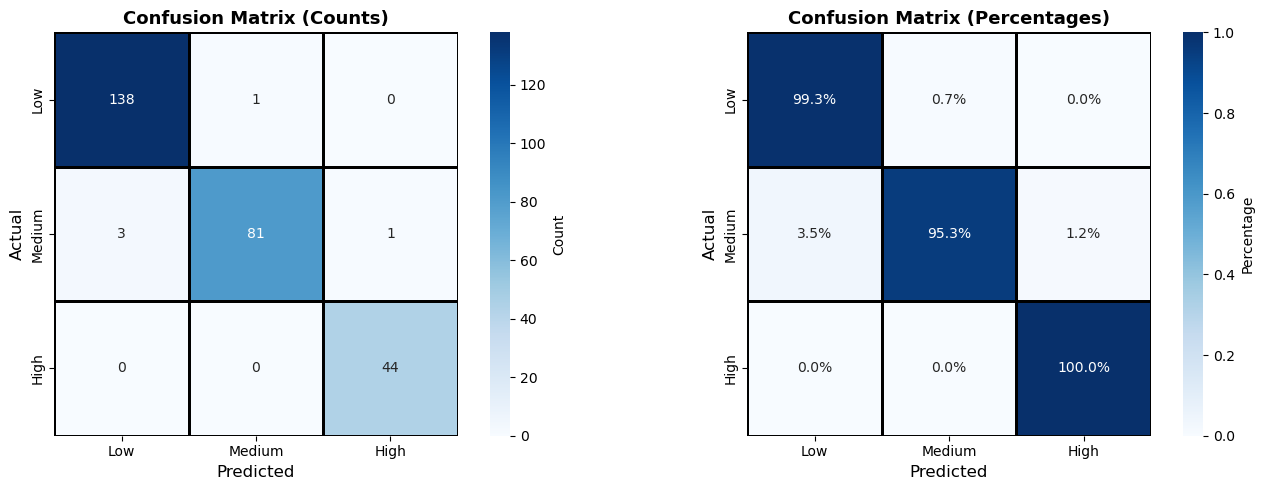

Plot saved: ./plots/10_confusion_matrix.png


In [27]:
# Calculate confusion matrices (counts and percentages)
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a visualization with two side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Confusion Matrix with Counts
# Ref: https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(
    cm,                                    # Confusion matrix data (actual counts)
    annot=True,                            # Display values in each cell
    fmt='d',                               # Format as integers (decimal)
    cmap='Blues',                          # Color scheme (light to dark blue)
    xticklabels=risk_order,                # X-axis labels: Low, Medium, High
    yticklabels=risk_order,                # Y-axis labels: Low, Medium, High
    cbar_kws={'label': 'Count'},           # Color bar label
    ax=axes[0],                            # Plot on first subplot
    square=True,                           # Make cells square-shaped
    linewidths=1,                          # Border width between cells
    linecolor='black'                      # Border color between cells
)
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)
axes[0].set_title('Confusion Matrix (Counts)', fontsize=13, fontweight='bold')

# Plot 2: Confusion Matrix with Percentages
sns.heatmap(
    cm_normalized,                         # Normalized confusion matrix (percentages)
    annot=True,                            # Display values in each cell
    fmt='.1%',                             # Format as percentages with 1 decimal place
    cmap='Blues',                          # Color scheme (light to dark blue)
    xticklabels=risk_order,                # X-axis labels: Low, Medium, High
    yticklabels=risk_order,                # Y-axis labels: Low, Medium, High
    cbar_kws={'label': 'Percentage'},      # Color bar label
    ax=axes[1],                            # Plot on the second subplot
    square=True,                           # Make cells square-shaped
    linewidths=1,                          # Border width between cells
    linecolor='black',                     # Border color between cells
    vmin=0, vmax=1                         # Scale color range from 0 to 1 (0% to 100%)
)
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=12)
axes[1].set_title('Confusion Matrix (Percentages)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('./plots/10_confusion_matrix.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

print("Plot saved: ./plots/10_confusion_matrix.png")


### Step 14.3: Performance Metrics by Risk Category

Visualize precision, recall, and F1-score for each risk category.


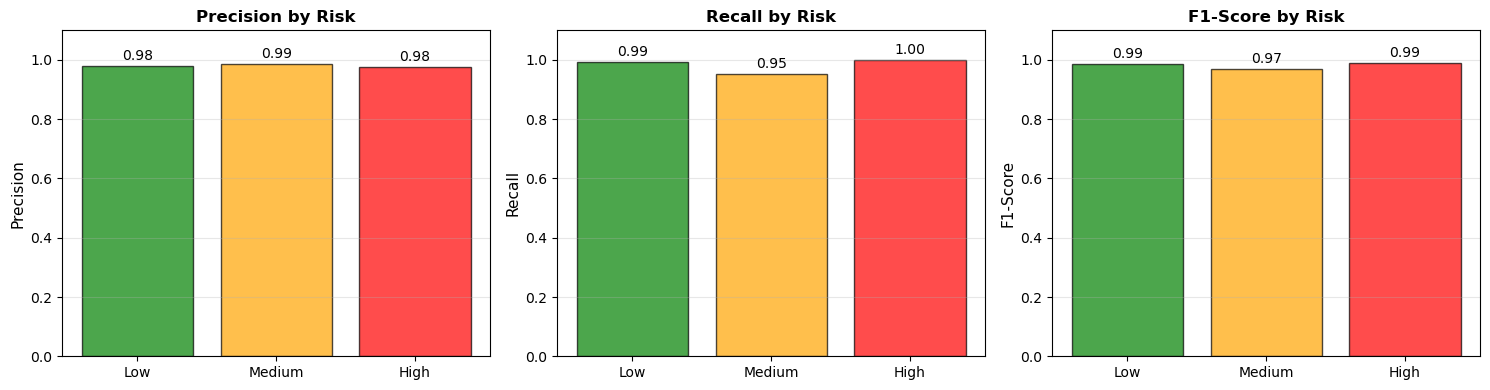

Plot saved: ./plots/11_per_risk_performance.png


In [28]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

metrics = [
    ('Precision', precision),
    ('Recall', recall),
    ('F1-Score', f1)
]

# Loop through each metric and create a bar chart
for idx, (metric_name, metric_values) in enumerate(metrics):
    # Create bar chart for current metric
    axes[idx].bar(
        risk_order,                        # X-axis: Low, Medium, High
        metric_values,                     # Y-axis: metric values for each risk category
        color=risk_colors,                 # Bar colors: green, orange, red
        edgecolor='black',                 # Black border around bars
        alpha=0.7                          # 70% opacity for softer appearance
    )
    axes[idx].set_ylabel(metric_name, fontsize=11)                          # Y-axis label (Precision, Recall, or F1-Score)
    axes[idx].set_title(f'{metric_name} by Risk', fontsize=12, fontweight='bold')  # Chart title
    axes[idx].set_ylim([0, 1.1])                                           # Y-axis range 0 to 1.1 (metrics are 0-1, extra space for labels)
    axes[idx].grid(axis='y', alpha=0.3)                                     # Horizontal grid lines for easier reading
    
    # Add value labels on top of each bar
    for i, v in enumerate(metric_values):
        axes[idx].text(
            i,                             # X position (bar index: 0, 1, 2)
            v + 0.02,                      # Y position (slightly above bar)
            f'{v:.2f}',                    # Text: value formatted to 2 decimal places
            ha='center',                   # Horizontal alignment: center
            fontsize=10                    # Font size for label
        )

plt.tight_layout()
plt.savefig('./plots/11_per_risk_performance.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

print("Plot saved: ./plots/11_per_risk_performance.png")


## Step 15: Conclusions

### Project Summary

This project implemented a complete data science workflow for health insurance risk classification:

1. **Data Processing**: Loaded and cleaned 1,338 health insurance records
2. **Feature Engineering**: Encoded categorical variables and normalized numeric features
3. **Data Storage**: Persisted data in SQLite database for SQL-based analysis
4. **Risk Classification**: Created rule-based system (Low/Medium/High risk)
5. **Exploratory Analysis**: Generated 11 visualizations examining feature distributions and correlations
6. **Machine Learning**: Built and trained a neural network classifier with TensorFlow/Keras
7. **Model Evaluation**: Achieved high accuracy in predicting risk categories

### Key Findings

- **Smoking status** is the strongest predictor of both risk classification and insurance costs
- **Age and BMI** show a positive correlation with higher risk categories
- **Sex and region** have minimal impact on risk classification
- Neural network successfully differentiates between Low, Medium, and High risk individuals

### Technical Implementation

- **Neural Network Architecture**: 9 input features → 16 hidden neurons → 3 output classes
- **Training Strategy**: Early stopping with validation monitoring to prevent overfitting
- **Data Preprocessing**: Min-max normalization for continuous variables, one-hot encoding for categories

This demonstrates end-to-end machine learning application from raw data to a trained model, with strong predictive performance for health insurance risk assessment.


# End